In [1]:
import numpy as np
import math

In [2]:
# Import libraries
from numpy import linalg
import pandas as pd
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import torch.nn.init as init
from torch import autograd

from torch import nn, optim
from time import time


In [3]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/1000
x_init_np = np.arange(start=a, stop=b+step, step=step)

In [4]:
import matplotlib.pyplot as plt
def draw_result(lst_iter, lst_loss):
    plt.plot(lst_iter, lst_loss, '-b', label='loss')
    
    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title("Loss")

    # save image
    plt.savefig("Loss"+".png")  # should before show method

    # show
    plt.show()

# plt.plot(test_error_vec)
# plt.show()

In [5]:
def draw_graph(lst_iter, lst_loss, lst_acc, title):
    plt.plot(lst_iter, lst_loss, '-b', label='true')
    plt.plot(lst_iter, lst_acc, '-r', label='neural network')

    plt.xlabel("x")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title+".png")  # should before show method

    # show
    plt.show()

In [6]:
def Loss3(u_hat, second_derivative_u_hat, x_data):
    # u_hat, u_star are n-dim pytorch tensor
    # second_derivative_u_hat is also a n-dim pytorch tensor
    result = torch.pow(torch.linalg.norm(second_derivative_u_hat[1:-1] + u_hat[1:-1] + torch.exp(x_data[1:-1]),ord = 2),2)/len(u_hat[1:-1]) + 1/2*(torch.pow(u_hat[0],2) + torch.pow(u_hat[-1],2))
    # result = 1/len(x_data)*torch.pow(torch.linalg.norm(second_derivative_u_hat + u_hat + torch.exp(x_data)), 2) + 1000*1/2*(torch.pow(u_hat[0],2) + torch.pow(u_hat[-1],2))
    return result

In [7]:
def run_train(lr = 0.001, num_e = 1000, Loss = Loss3, true_sol = None):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    time0 = time()
    num_e = num_e
    iter = []
    test_error_vec = []
    # print(model.parameters())
    scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.1)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    for e in range(num_e):
        running_loss = 0
        # call zero_Grad
        optimizer.zero_grad() 
        # Compute u_hat, d2u_hat
        u_hat = torch.tensor(np.array([]))
        d2u_hat = torch.tensor(np.array([]))
        for x in x_init_np:
            x_tensor = torch.tensor(np.array([x]), requires_grad= True)
            temp = model(x_tensor.float())
            # u_hat.append(temp.clone().item())
            u_hat = torch.hstack([u_hat, temp])
            # first_derivative = autograd.grad(model(x_tensor.float()), x_tensor, create_graph=True)[0]
            # second_derivative = autograd.grad(first_derivative, x_tensor)[0]
            # # d2u_hat.append(second_derivative.detach().numpy()[0])
            # d2u_hat = torch.hstack([d2u_hat, second_derivative])
            # d2u_hat.append(second_derivative.clone().item())
        d2u_hat = u_hat.clone()    
        d2u_hat[1:-1] = (u_hat[0:-2] + u_hat[2:] - 2*u_hat[1:-1])/step**2     
        # loss and backward
        # print(u_hat)
        # print(d2u_hat)
        # u_hat = torch.tensor(np.array(u_hat))
        # d2u_hat = torch.tensor(np.array(d2u_hat))
        loss = Loss(u_hat,d2u_hat,x_init)
        loss.backward()
        # print(type(list(model.parameters())[0]))
        # print(x_init.grad)
        # optimizer.step()
        # torch.nn.utils.clip_grad_norm(model.parameters(), 1)
        optimizer.step() 

        # print(type(list(model.parameters())[0]))

        running_loss += loss.clone().item()    
        if (e % 100 == 0):
            print(f"The running loss at {e} iteration is: {running_loss}")
        test_error_vec.append(running_loss)
        iter.append(e)
        # print("----------------------------------------------------")
        # if (num_e % 2 == 0):
        # scheduler1.step()
        #     scheduler2.step()

    draw_result(iter, test_error_vec)
    # print(f"The running loss at {num_e} iteration is: {test_error_vec[-1]}")

    if(true_sol):
      y_true = true_sol(x_init_np)
      draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), 'Solutions')
      print(np.mean(np.square(y_true -  u_hat.clone().detach().numpy())))


In [8]:
def Loss4(u_hat, second_derivative_u_hat, x_data):
    # u_hat, u_star are n-dim pytorch tensor
    # second_derivative_u_hat is also a n-dim pytorch tensor
    result = torch.pow(torch.linalg.norm(-second_derivative_u_hat[1:-1] + u_hat[1:-1] - torch.sin(4.0*np.pi*x_data[1:-1]),ord = 2),2)/len(u_hat[1:-1]) + 1/2*(torch.pow(u_hat[0],2) + torch.pow(u_hat[-1],2))
    # result = 1/len(x_data)*torch.pow(torch.linalg.norm(second_derivative_u_hat + u_hat + torch.exp(x_data)), 2) + 1000*1/2*(torch.pow(u_hat[0],2) + torch.pow(u_hat[-1],2))
    return result

In [9]:
def u_star_h(x):
  return 1/(16*np.pi**2 + 1 )*np.sin(4*np.pi*x)

In [10]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/1000
x_init_np = np.arange(start=a, stop=b+step, step=step)

In [11]:
x_init_np = np.arange(start=a, stop=b, step=step)
x_init = torch.tensor(x_init_np, requires_grad= True)
# print(x_init)
print(x_init.shape)

torch.Size([1000])


Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Tanh()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): Tanh()
  (6): Linear(in_features=10, out_features=1, bias=True)
  (7): Tanh()
)
The running loss at 0 iteration is: 0.5935919909674743
The running loss at 100 iteration is: 0.46080284981769104
The running loss at 200 iteration is: 0.4530754720151159
The running loss at 300 iteration is: 0.4474995555077421
The running loss at 400 iteration is: 0.43099479254715367
The running loss at 500 iteration is: 0.1817940124976939
The running loss at 600 iteration is: 0.025903686501937064
The running loss at 700 iteration is: 0.01938668655411167
The running loss at 800 iteration is: 0.014247527117484497
The running loss at 900 iteration is: 0.009792328379712646
The running loss at 1000 iteration is: 0.00760502510009949
The running loss at 1100 iteration is: 0.006079724635898171
The 

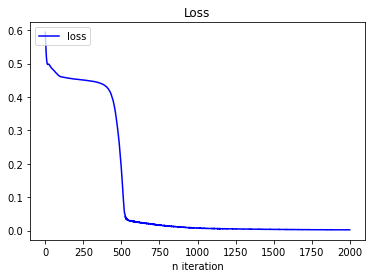

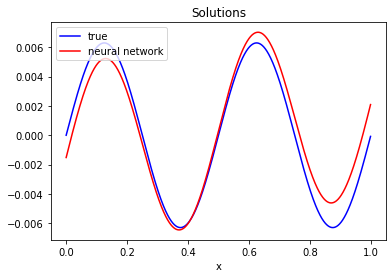

1.2168374823353204e-06


In [15]:
# u = sigma(W4(sigma(W3... x)))

input_size = 1
output_size = 1
k = 10
# hidden_sizes = [5, 5, 5, 5, 5, 5, 5]


# module1 = nn.Linear(input_size, hidden_sizes[0])
# init.xavier_normal_(module1.weight)

# module2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
# init.xavier_normal_(module2.weight)

# module3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
# init.xavier_normal_(module3.weight)

# module4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
# init.xavier_normal_(module4.weight)

# module5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
# init.xavier_normal_(module5.weight)

model = nn.Sequential(nn.Linear(input_size, k),
                      nn.Tanh(),

                    #   nn.Linear(k, k),
                    #   nn.Tanh(),

                    #   nn.Linear(k, k),
                    #   nn.SELU(),
                      
                    #   nn.Linear(k, k),
                    #   nn.SELU(),

                    #   nn.Linear(k, k),
                    #   nn.Tanh(),

                    #   nn.Linear(k, k),
                    #   nn.Tanh(),
                      
                    #   nn.Linear(k, k),
                    #   nn.Tanh(),

                    #   nn.Linear(k, k),
                    #   nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, output_size),
                      nn.Tanh(),

                      )

print(model)

# criterion = nn.MSELoss(size_average=False)
# criterion = nn.HingeEmbeddingLoss()
run_train( lr = 0.01, num_e = 2000,Loss = Loss4,true_sol=u_star_h)
